# import packages

In [1]:
import rmsp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

import sys
sys.path.append('../python_modules/')  # Defining the path to my modules
from conditional_distributions import ConditionalMG, ConditionalML
import multi_cross_validation

# load data

In [2]:
# Loading data
data = pd.read_csv('wl_semisyn_bivariate.csv')

# Converting Pandas Dataframe into a RMSP Point Data
data = rmsp.PointData(data, x='x', y="y")
data.drop('x1_shift', axis=1, inplace=True)
data.rename(columns={'x1':'var1', 'tg':'var2'}, inplace=True)

type(data)

rmsp.core.point.PointData

# sub-sampling and splitting data

In [3]:
# Define threshold on the reference variable
thr_var = 'var1'
threshold = data[thr_var].quantile(0.50)

# fractions to select below and above threshold
frac_above = 0.60
frac_below = 0.40

# Select samples above and below the median threshold
samples_above_threshold = data[data[thr_var] > threshold]
samples_below_threshold = data[(data[thr_var] < threshold)]

# Sample subsets
complete_set_above = samples_above_threshold.sample(frac=frac_above, random_state=42)
complete_set_below = samples_below_threshold.sample(frac=frac_below, random_state=42)

# Combine subsets
complete_set = pd.concat([complete_set_above, complete_set_below])

# Remaining samples (excluding complete set) go to missing set
missing_set = data.drop(complete_set.index)

# Split the "complete" subset into validation and modeling subsets
valid_set = complete_set.sample(frac=0.15, random_state=42)
model_set = complete_set.drop(valid_set.index)

# Create flags in the main dataframe
data['missing'] = 0
data['valid'] = 0
data['model'] = 0
data.loc[missing_set.index, 'missing'] = 1
data.loc[valid_set.index,   'valid']   = 1
data.loc[model_set.index,   'model']   = 1

# instantiate cv object

In [4]:
# Create mg model instance
model_mg = ConditionalMG()

# Create ml model instance
model_ml = ConditionalML(regressor=GradientBoostingRegressor,
                         r_squared=0.40,
                         reg_hyperparams={'alpha': 0.9,
                                         'ccp_alpha': 0.0,
                                         'criterion': 'friedman_mse',
                                         'init': None,
                                         'learning_rate': 0.05,
                                         'loss': 'squared_error',
                                         'max_depth': 2,
                                         'max_features': None,
                                         'max_leaf_nodes': None,
                                         'min_impurity_decrease': 0.0,
                                         'min_samples_leaf': 4,
                                         'min_samples_split': 4,
                                         'min_weight_fraction_leaf': 0.0,
                                         'n_estimators': 100,
                                         'n_iter_no_change': None,
                                         'random_state': 42,
                                         'subsample': 0.8,
                                         'tol': 0.0001,
                                         'validation_fraction': 0.1,
                                         'verbose': 0,
                                         'warm_start': False}
                                        )

In [5]:
# Initialize the class
workflow_cv = multi_cross_validation.Multi_Scenario_CV(
    random_state=42,
    model_ml=model_ml,
    model_mg=model_mg
)

# benchmarking

In [6]:
# Instantiate the transformers
# Each variable individually
despiker = rmsp.DespikeMVSpatial()
nscorer_var1 = rmsp.NSTransformer(warn_no_wt=False)
nscorer_var2 = rmsp.NSTransformer(warn_no_wt=False)

In [9]:
# One variable at a time
data_dspk = despiker.fit_transform(model_set, variables=['var1', 'var2'])
data_dspk[['var1', 'var2']] = data_dspk.values

# Fit and transform predictors individually
nscorer_var1.fit(data_dspk['var1'])
model_set['ns_var1'] = nscorer_var1.transform(data_dspk['var1'])

# Fit and transform target individually
nscorer_var2.fit(data_dspk['var2'])
model_set['ns_var2'] = nscorer_var2.transform(data_dspk['var2'])

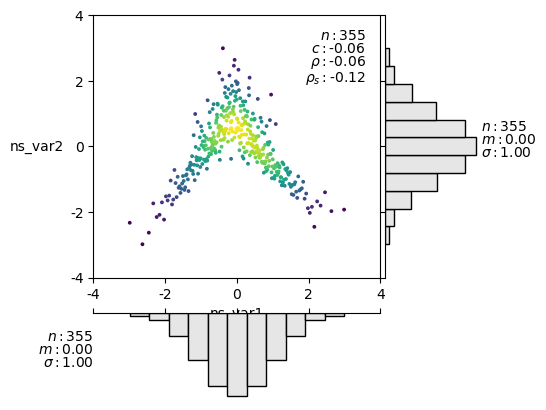

In [10]:
# Check scatter plot
fig = model_set.scatplots(['ns_var2', 'ns_var1'], s=3, figsize=(5, 5), num_sample=1000, stats='all', plot_marginals=True)

In [11]:
# separating datasets
data_labels = model_set['ns_var2']
data_prepared = model_set[['ns_var1']]

In [12]:
# fitting
model_mg.fit(data_prepared.values, data_labels.values)

# Predicting training data
means_mg_tr, _, _ = model_mg.predict(data_prepared.values)

# Checking
mse_mg_ref = mean_squared_error(data_labels.values, means_mg_tr)
rmse_mg_ref = np.sqrt(mse_mg_ref)
r2_mg_ref = r2_score(data_labels, means_mg_tr)

# Printing results
print(f'RMSE calculated on training data: {np.round(rmse_mg_ref, 4)}')
print(f'R2 calculated on training data: {np.round(r2_mg_ref, 4)}')

RMSE calculated on training data: 0.9963
R2 calculated on training data: 0.0039


In [13]:
model_ml.fit(data_prepared.values, data_labels.values)

# Predicting training data
means_ml_tr, _, _ = model_ml.predict(data_prepared.values)

# Checking
mse_ml_ref = mean_squared_error(data_labels.values, means_ml_tr)
rmse_ml_ref = np.sqrt(mse_ml_ref)
r2_ml_ref = r2_score(data_labels, means_ml_tr)

# Printing results
print(f'RMSE calculated on training data: {np.round(rmse_ml_ref, 4)}')
print(f'R2 calculated on training data: {np.round(r2_ml_ref, 4)}')

RMSE calculated on training data: 0.4902
R2 calculated on training data: 0.7589


# k-folding

In [36]:
# Run for multiple splits (fixed test proportion)
dict_kfolds = workflow_cv.multi_kfold_splitting(data=model_set, var_x=['var1'], var_y='var2', n_splits_list=[15, 10, 5, 3, 2])


Running k-fold CV workflow for k=15
Iteration 15/15 running...
Elapsed Time: 2.07 minutes

Running k-fold CV workflow for k=10
Iteration 10/10 running...
Elapsed Time: 1.67 minutes

Running k-fold CV workflow for k=5
Iteration 5/5 running...
Elapsed Time: 0.58 minutes

Running k-fold CV workflow for k=3
Iteration 3/3 running...
Elapsed Time: 0.33 minutes

Running k-fold CV workflow for k=2
Iteration 2/2 running...
Elapsed Time: 0.33 minutes


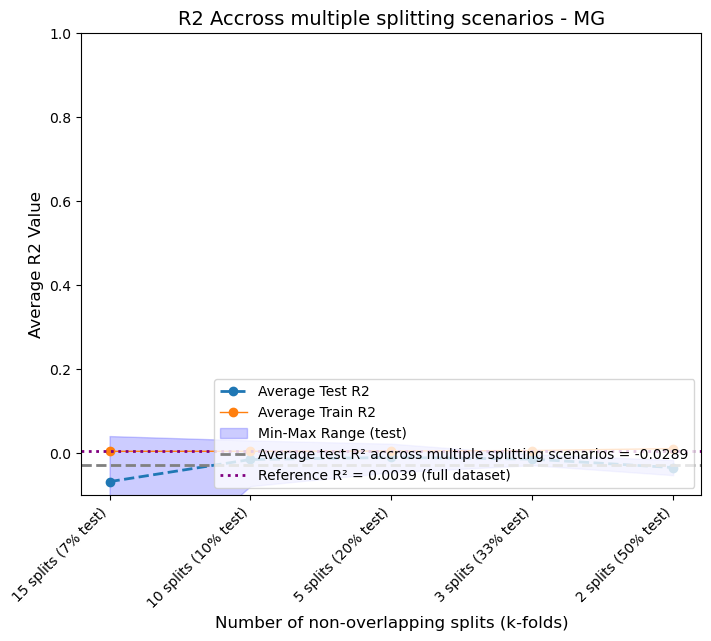

In [37]:
multi_cross_validation.plot_r2_accross_kf(dict_kfolds, r2_ref=r2_mg_ref, approach='mg')

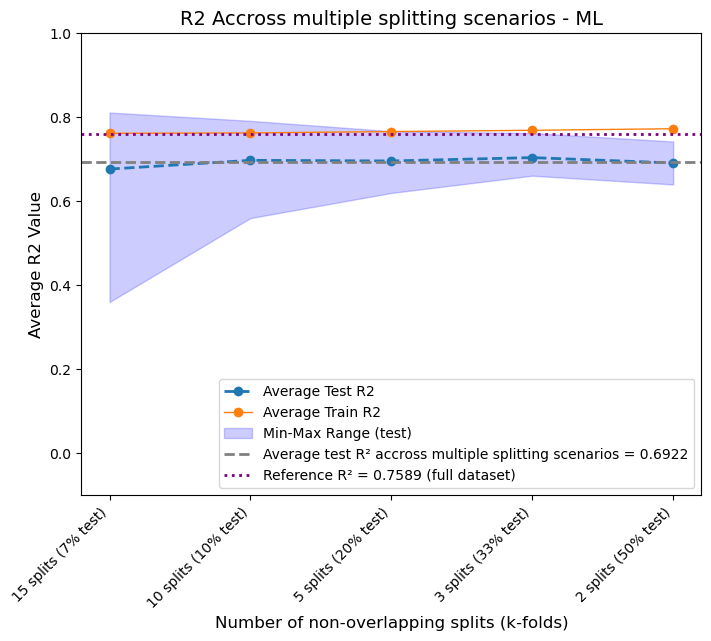

In [38]:
multi_cross_validation.plot_r2_accross_kf(dict_kfolds, r2_ref=r2_ml_ref, approach='ml')

In [39]:
multi_cross_validation.print_result_table_cv(dict_kfolds, n_splits=10, test_prop=0.10, approach='ml', subset='test')

,Metrics,R²,RMSE
0,Minimum,0.5591,0.4896
1,Maximum,0.7907,0.7098
2,Average,0.6966,0.5423
3,Variance,0.0047,0.0041


In [40]:
multi_cross_validation.print_result_table_cv(dict_kfolds, n_splits=10, test_prop=0.10, approach='ml', subset='train')

,Metrics,R²,RMSE
0,Minimum,0.7513,0.4779
1,Maximum,0.7707,0.4978
2,Average,0.7619,0.4870
3,Variance,0.0000,0.0000


# checking r2 distribution

In [41]:
alpha = 0.1

r2_ml_train = dict_kfolds[10][alpha]['all_metrics']['r2_ml']['train'].tolist()
r2_ml_test  = dict_kfolds[10][alpha]['all_metrics']['r2_ml']['test'].tolist()

df_r2_ml = pd.DataFrame({
        'r2_ml_train': r2_ml_train,
        'r2_ml_test': r2_ml_test
})

In [42]:
df_r2_ml_columns = df_r2_ml.columns.to_list()

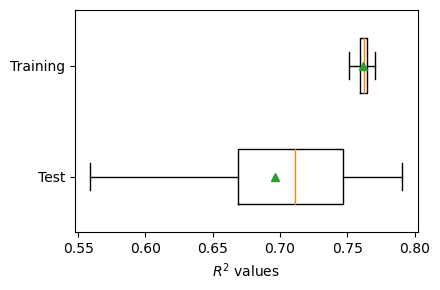

In [43]:
plt.figure(figsize=(4.5, 3))
plt.boxplot([r2_ml_test, r2_ml_train], labels=['Test', 'Training'], whis=(0, 100), widths=0.5, vert=False, showmeans=True)

plt.xlabel('$R^2$ values')
# plt.title('Box Plot of Two Lists')
plt.tight_layout()
plt.show()